In [1]:
import sys
sys.path.append("..\..")

import matplotlib.pyplot as plt

from src.data.datasets.overlaps import OverlapsDataset
from src.nn.inference.OverlapsNet import OverlapsNetInference
from src.data.loaders.overlaps import get_overlaps_dataloader

In [2]:
inference = OverlapsNetInference("../../src/nn/weights/OverlapsNet/best.ckpt")
test_dataset = OverlapsDataset.from_path("../../datasets/PlagiNet/", split="test")

bootstrap_results = inference.bootstrap_inference(
    dataset=test_dataset,
    dataloader_fn=get_overlaps_dataloader
)

mean_auc = bootstrap_results["auc"]["mean"]
lower_auc = bootstrap_results["auc"]["lower"]
upper_auc = bootstrap_results["auc"]["upper"]
fpr = bootstrap_results["roc"]["fpr"]
tpr_mean = bootstrap_results["roc"]["tpr_mean"]
tpr_lower = bootstrap_results["roc"]["tpr_lower"]
tpr_upper = bootstrap_results["roc"]["tpr_upper"]

Calculating CI: 100%|██████████| 1000/1000 [00:56<00:00, 17.64it/s]


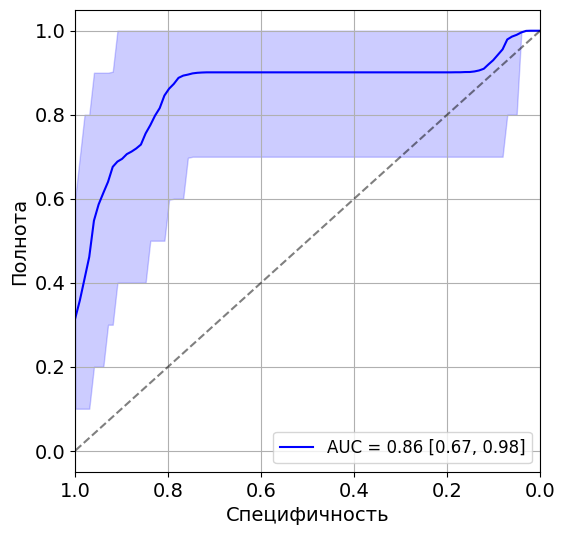

In [3]:
ci_alpha = 0.2
labels_fontsize=14
legend_fontsize=12
title_fontsize=16
ticks_fontsize=14

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(1-fpr, tpr_mean, label=f"AUC = {mean_auc:.2f} [{lower_auc:.2f}, {upper_auc:.2f}]", color='blue')
ax.fill_between(1-fpr, tpr_lower, tpr_upper, alpha=ci_alpha, color='blue')

ax.plot([0, 1], [1, 0], color="black", linestyle="--", alpha=0.5)
ax.set_xlabel("Специфичность", fontsize=labels_fontsize)
ax.set_ylabel("Полнота", fontsize=labels_fontsize)
ax.set_xlim((1, 0))
ax.legend(loc="lower right", fontsize=legend_fontsize)
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)